In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from esem import gp_model
from eofs.xarray import Eof
import gpflow

2025-02-06 18:29:09.259802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738891749.279090   45207 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738891749.284958   45207 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 18:29:09.307608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_files= ['ssp126', 'ssp370', 'ssp585', 'picontrol']

In [3]:
NEOFS = 5

In [4]:
training_data_path = './inputs/'

def get_Xtrain(datasets, n_eofs=5):
    """
    Args:
        datasets list(str): dataset to create features for
        n_eofs (int): number of eofs to create
    """
    
    if isinstance(datasets, str):
        datasets = [datasets]
        
    X = xr.concat([xr.open_dataset(training_data_path+f'inputs_{d}.nc') for d in datasets], dim='time')
    X = X.assign_coords(time=np.arange(len(X.time)))
    
    # compute eofs for pr
    pr_solver = Eof(X['pr'])
    pr_eofs = pr_solver.eofsAsCorrelation(neofs=n_eofs)
    pr_pcs = pr_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    pr_df = pr_pcs.to_dataframe().unstack('mode')
    pr_df.columns = [f"pr_{i}" for i in range(n_eofs)]

    # compute eofs for rlds
    rlds_solver = Eof(X['rlds'])
    rlds_eofs = rlds_solver.eofsAsCorrelation(neofs=n_eofs)
    rlds_pcs = rlds_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    rlds_df = pr_pcs.to_dataframe().unstack('mode')
    rlds_df.columns = [f"rlds_{i}" for i in range(n_eofs)]

    # compute eofs for rlds
    rsds_solver = Eof(X['rsds'])
    rsds_eofs = rsds_solver.eofsAsCorrelation(neofs=n_eofs)
    rsds_pcs = rsds_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    rsds_df = rsds_pcs.to_dataframe().unstack('mode')
    rsds_df.columns = [f"rsds_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    sfcwind_solver = Eof(X['sfcwind'])
    sfcwind_eofs = sfcwind_solver.eofsAsCorrelation(neofs=n_eofs)
    sfcwind_pcs = sfcwind_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    sfcwind_df = sfcwind_pcs.to_dataframe().unstack('mode')
    sfcwind_df.columns = [f"sfcwind_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    tas_solver = Eof(X['tas'])
    tas_eofs = tas_solver.eofsAsCorrelation(neofs=n_eofs)
    tas_pcs = tas_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    tas_df = tas_pcs.to_dataframe().unstack('mode')
    tas_df.columns = [f"tas_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    tasmax_solver = Eof(X['tasmax'])
    tasmax_eofs = tasmax_solver.eofsAsCorrelation(neofs=n_eofs)
    tasmax_pcs = tasmax_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    tasmax_df = tasmax_pcs.to_dataframe().unstack('mode')
    tasmax_df.columns = [f"tasmax_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    tasmin_solver = Eof(X['tasmin'])
    tasmin_eofs = tasmin_solver.eofsAsCorrelation(neofs=n_eofs)
    tasmin_pcs = tasmin_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    tasmin_df = tasmin_pcs.to_dataframe().unstack('mode')
    tasmin_df.columns = [f"tasmin_{i}" for i in range(n_eofs)]
    
    
    inputs=pd.concat([pr_df, rlds_df, rsds_df, sfcwind_df, tas_df, tasmax_df, tasmin_df], axis=1)
    
    return inputs, (pr_solver, rlds_solver, rsds_solver, sfcwind_solver, tas_solver, tasmax_solver, tasmin_solver)

In [5]:
Xtrain, eof_solvers = get_Xtrain(train_files, NEOFS)

In [6]:
def get_Ytrain(datasets):
        
    if isinstance(datasets, str):
        datasets = [datasets]
        
    Y = xr.concat([xr.open_dataset(f'./processed_output/lpjml_{d}_2015_2100.nc') for d in datasets], dim='time')
    
    return Y

In [7]:
Ytrain = get_Ytrain(train_files)

In [8]:
Ytrain_yield = Ytrain['soy'].values.reshape(-1, 360*720)

In [9]:
training_data_path = './inputs/'
def get_Xtest(file, eof_solvers, n_eofs=5):
    # pr_solver, rlds_solver, rsds_solver, sfcwind_solver, tas_solver, tasmax_solver, tasmin_solver
    X = xr.open_dataset(training_data_path+f'inputs_{file}.nc')

    pr_pcs = eof_solvers[0].projectField(X['pr'], neofs=n_eofs, eofscaling=1)
    pr_df = pr_pcs.to_dataframe().unstack('mode')
    pr_df.columns = [f"pr_{i}" for i in range(n_eofs)]

    rlds_pcs = eof_solvers[1].projectField(X['rlds'], neofs=n_eofs, eofscaling=1)
    rlds_df = rlds_pcs.to_dataframe().unstack('mode')
    rlds_df.columns = [f"rlds_{i}" for i in range(n_eofs)]

    rsds_pcs = eof_solvers[2].projectField(X['rsds'], neofs=n_eofs, eofscaling=1)
    rsds_df = rsds_pcs.to_dataframe().unstack('mode')
    rsds_df.columns = [f"rsds_{i}" for i in range(n_eofs)]

    sfcwind_pcs = eof_solvers[0].projectField(X['sfcwind'], neofs=n_eofs, eofscaling=1)
    sfcwind_df = sfcwind_pcs.to_dataframe().unstack('mode')
    sfcwind_df.columns = [f"sfcwind_{i}" for i in range(n_eofs)]
    
    tas_pcs = eof_solvers[0].projectField(X['tas'], neofs=n_eofs, eofscaling=1)
    tas_df = tas_pcs.to_dataframe().unstack('mode')
    tas_df.columns = [f"tas_{i}" for i in range(n_eofs)]
    
    tasmax_pcs = eof_solvers[0].projectField(X['tasmax'], neofs=n_eofs, eofscaling=1)
    tasmax_df = tasmax_pcs.to_dataframe().unstack('mode')
    tasmax_df.columns = [f"tasmax_{i}" for i in range(n_eofs)]
    
    tasmin_pcs = eof_solvers[0].projectField(X['tasmin'], neofs=n_eofs, eofscaling=1)
    tasmin_df = tasmin_pcs.to_dataframe().unstack('mode')
    tasmin_df.columns = [f"tasmin_{i}" for i in range(n_eofs)]

    
    
    inputs=pd.concat([pr_df, rlds_df, rsds_df, sfcwind_df, tas_df, tasmax_df, tasmin_df], axis=1)
    
    return inputs

In [10]:
Xtest = get_Xtest('historical', eof_solvers, NEOFS)

In [11]:
Ytest = xr.open_dataset('./processed_output/lpjml_historical_1850_2014.nc').compute()

In [12]:
yield_truth = Ytest['soy']

In [13]:
train_nan_mask = Xtrain.isna().any(axis=1).values
Xtrain = Xtrain.dropna(axis=0, how='any')
Ytrain_yield = Ytrain_yield[~train_nan_mask]
assert Xtrain.shape[0]==Ytrain_yield.shape[0]

In [14]:
test_nan_mask = Xtest.isna().any(axis=1).values
Xtest = Xtest.dropna(axis=0, how='any')
yield_truth = yield_truth[~test_nan_mask]

In [15]:
mask_all_nan_by_col = np.isnan(Ytrain_yield).all(axis=0)

In [16]:
np.isnan(Ytrain_yield).sum() - 258*mask_all_nan_by_col.sum()

16506555

In [17]:
Ytrain_yield_dropped = Ytrain_yield[:, ~mask_all_nan_by_col]

In [18]:
Y_imputed = np.nan_to_num(Ytrain_yield_dropped, nan=0.0)

In [19]:
# Standardize predictand fields
train_yield_mean, train_yield_std = Y_imputed.mean(), Y_imputed.std()
Y_imputed = (Y_imputed - train_yield_mean) / train_yield_std

In [765]:
kernel = (
    gpflow.kernels.Matern32(active_dims=[0, 1, 2, 3, 4], lengthscales=[1.0]*5) #+  # pr
    #gpflow.kernels.Matern32(active_dims=[5, 6, 7, 8, 9], lengthscales=[1.0]*5) +  # rlds
    #gpflow.kernels.Matern32(active_dims=[10, 11, 12, 13, 14], lengthscales=[0.5]*5) +  # rsds
    #gpflow.kernels.Matern32(active_dims=[15, 16, 17, 18, 19], lengthscales=[1.0]*5) +  # sfcwind
    #gpflow.kernels.Matern32(active_dims=[20, 21, 22, 23, 24], lengthscales=[0.3]*5) +  # tas
    #gpflow.kernels.Matern32(active_dims=[25, 26, 27, 28, 29], lengthscales=[0.3]*5) +  # tasmax
    #gpflow.kernels.Matern32(active_dims=[30, 31, 32, 33, 34], lengthscales=[0.8]*5)    # tasmin
)


In [766]:
np.random.seed(5)

"""
In Gaussian Processes, a mean function represents the "prior mean" or the expected value
of the function at any input point before observing any data. By default, this mean is 
zero, but here a constant mean is set.
"""
mean = gpflow.mean_functions.Constant()

model = gpflow.models.GPR(data=(Xtrain.astype(np.float64), # cast to float64 because gpflow requires numerical stability
                                Y_imputed.astype(np.float64)),
                          kernel = kernel,
                          mean_function = mean)

In [767]:
# define optimizer
optimizer = gpflow.optimizers.Scipy()

# train
optimizer.minimize(model.training_loss,
                   variables=model.trainable_variables,
                   options=dict(disp=True, maxiter=5000))

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 4528716.601661531
        x: [ 1.559e+01  2.310e+01  2.219e+01  1.212e+01  1.613e+01
             5.392e-01 -2.523e+00 -9.498e-02]
      nit: 57
      jac: [-9.354e-01 -6.641e-02 -2.952e-01  2.674e+00 -6.175e-01
             3.033e+00  2.473e-01 -1.798e+00]
     nfev: 67
     njev: 67
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [768]:
Xtest64 = Xtest.astype(np.float64)

In [769]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(Xtest64.values) # predicted mean of GP, predicted variance of GP
posterior_mean = standard_posterior_mean * train_yield_std + train_yield_mean # transform mean prediction to original scale
posterior_stddev = np.sqrt(standard_posterior_var) * train_yield_std # transform variance prediction to original scale standard deviation

In [770]:
posterior_yield_mean_full = np.full((Xtest64.shape[0], Ytrain_yield.shape[1]), np.nan)  # fill with NaN
posterior_yield_mean_full[:, ~mask_all_nan_by_col] = posterior_mean

posterior_yield_stddev_full = np.full((Xtest64.shape[0], Ytrain_yield.shape[1]), np.nan)  # fill with NaN
posterior_yield_stddev_full[:, ~mask_all_nan_by_col] = posterior_stddev

In [771]:
# put output back into xarray format for calculating RMSE/plotting
posterior_yield = np.reshape(posterior_yield_mean_full, [yield_truth.shape[0], 360, 720])
posterior_yield_stddev = np.reshape(posterior_yield_stddev_full, [yield_truth.shape[0], 360, 720])

posterior_yield_data = xr.DataArray(posterior_yield, dims=yield_truth.dims, coords=yield_truth.coords)
posterior_yield_std_data = xr.DataArray(posterior_yield_stddev, dims=yield_truth.dims, coords=yield_truth.coords)

In [772]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

In [773]:
# Compute RMSEs
print(f"RMSE at {yield_truth[35]['time'].values}: {get_rmse(yield_truth[35], posterior_yield_data[35])}")
print(f"RMSE at {yield_truth[85]['time'].values}: {get_rmse(yield_truth[85], posterior_yield_data[85])}")
print(f"RMSE {yield_truth[30]['time'].values}-{yield_truth[41]['time'].values-1}: {get_rmse(yield_truth[30:41], posterior_yield_data[30:41]).mean()}")
print(f"RMSE {yield_truth[75]['time'].values}-{yield_truth[-1]['time'].values}: {get_rmse(yield_truth[75:], posterior_yield_data[75:]).mean()}")
print(f"RMSE {yield_truth[-20]['time'].values}-{yield_truth[-1]['time'].values}: {get_rmse(yield_truth[-20:], posterior_yield_data[-20:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(yield_truth[-20:].mean(dim='time'), posterior_yield_data[-20:].mean(dim='time'))}")

RMSE at 1885.0: 1.7288174004343766
RMSE at 1935.0: 2.055986917878777
RMSE 1880.0-1890.0: 1.9108074596015343
RMSE 1925.0-2014.0: 1.7620297438138466
RMSE 1995.0-2014.0: 1.6066102437803624
RMSE average last 20y: 1.3955717446020055


In [774]:
def xarray_describe(dataarray):
    return xr.Dataset({
        "count": dataarray.count(),
        "mean": dataarray.mean(),
        "std": dataarray.std(),
        "min": dataarray.min(),
        #"25%": dataarray.quantile(0.25),
        "50%": dataarray.median(),
        "75%": dataarray.quantile(0.75),
        "max": dataarray.max()
    })

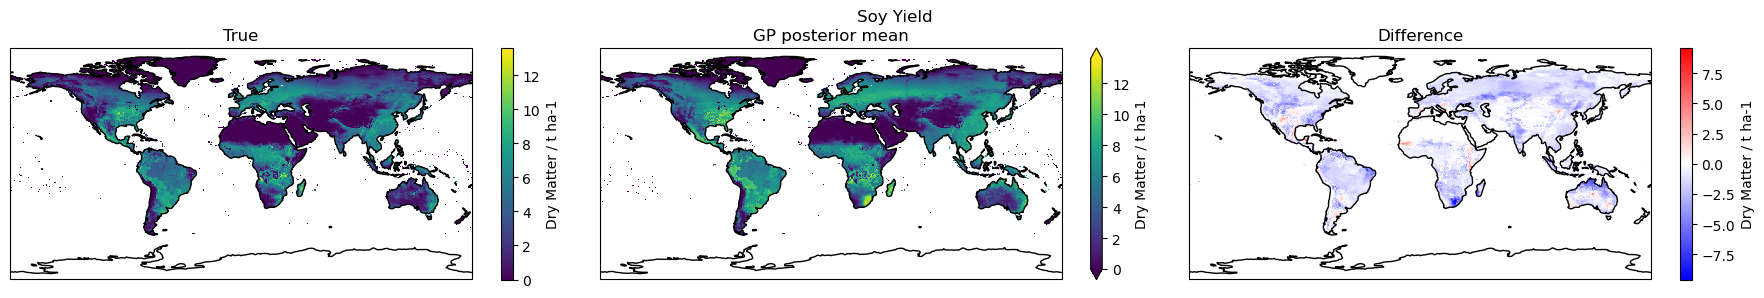

In [775]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors

# Sliced means
truth_mean = yield_truth.sel(time=2000)
posterior_mean = posterior_yield_data.sel(time=2000)
difference = truth_mean - posterior_mean

# Get ranges
tmin, tmax = float(truth_mean.min()), float(truth_mean.max())
pmin, pmax = float(posterior_mean.min()), float(posterior_mean.max())
dmin, dmax = float(difference.min()), float(difference.max())

# For the truth and posterior plots:
# add a small buffer to make sure you see a gradient in the map
buffer = 0.001  # adjust as needed
vmin_pr = tmin - buffer
vmax_pr = tmax + buffer

# For the difference plot, use a symmetric scale around 0
abs_max_diff = max(abs(dmin), abs(dmax))
diffnorm = colors.TwoSlopeNorm(vcenter=0., vmin=-abs_max_diff, vmax=abs_max_diff)

# Plot
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,3))
fig.suptitle('Soy Yield')

# 1) Truth
ax1 = plt.subplot(131, projection=proj)
truth_mean.plot(
    ax=ax1, cmap="viridis",
    vmin=vmin_pr, vmax=vmax_pr,
    cbar_kwargs={"label":"Dry Matter / t ha-1"}
)
ax1.coastlines()
ax1.set_title('True')

# 2) Posterior
ax2 = plt.subplot(132, projection=proj)
posterior_mean.plot(
    ax=ax2, cmap="viridis",
    vmin=vmin_pr, vmax=vmax_pr,
    cbar_kwargs={"label":"Dry Matter / t ha-1"}
)
ax2.coastlines()
ax2.set_title('GP posterior mean')

# 3) Difference
ax3 = plt.subplot(133, projection=proj)
difference.plot(
    ax=ax3, cmap="bwr",
    norm=diffnorm,
    cbar_kwargs={"label":"Dry Matter / t ha-1"}
)
ax3.coastlines()
ax3.set_title('Difference')

plt.tight_layout()
plt.show()


In [776]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.09497801]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.9986440597088654
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[15.58659, 23.10221, 22.19175..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.07719659804574276
